In [1]:
from pynq import Overlay, allocate, PL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PL.reset()
overlay = Overlay('pathtracer.bit')

In [2]:
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['render_0', 'axi_dma_b', 'axi_dma_g', 'axi_dma_r', 'processing_system7_0']


In [3]:
pathtracer     = overlay.render_0
#dma_0 = overlay.axi_dma_0

dma_r_recv = overlay.axi_dma_r.recvchannel
dma_g_recv = overlay.axi_dma_g.recvchannel
dma_b_recv = overlay.axi_dma_b.recvchannel

CONTROL_REGISTER = 0x0

def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

WIDTH_REGISTER = get_register_offset(overlay, 'render_0', 'width')
HEIGHT_REGISTER = get_register_offset(overlay, 'render_0', 'height')
SAMPLES_REGISTER = get_register_offset(overlay, 'render_0', 'samples_per_pixel')

In [4]:
def process_buffers_fpga(r_buffer, g_buffer, b_buffer):
    dma_r_recv.transfer(r_buffer)
    dma_g_recv.transfer(g_buffer)
    dma_b_recv.transfer(b_buffer)
    dma_r_recv.wait()
    dma_g_recv.wait()
    dma_b_recv.wait()

def process_fpga(width, height, num_samples=2):
    
    pathtracer.write(WIDTH_REGISTER, width)
    pathtracer.write(HEIGHT_REGISTER, height)
    pathtracer.write(SAMPLES_REGISTER, num_samples)
    pathtracer.write(CONTROL_REGISTER, 0x01)
    
    r_buffer = allocate(shape=(width*height,), dtype=np.int32)
    g_buffer = allocate(shape=(width*height,), dtype=np.int32)
    b_buffer = allocate(shape=(width*height,), dtype=np.int32)
    
    process_buffers_fpga(r_buffer, g_buffer, b_buffer)
    
    image = np.zeros((height, width, 3), dtype=np.int32)
    for y in range(height):
        for x in range(width):
            image[y, x, 0] = r_buffer[x + y*width]
            image[y, x, 1] = g_buffer[x + y*width]
            image[y, x, 2] = b_buffer[x + y*width]
    
    return image

image = process_fpga(400, 400)

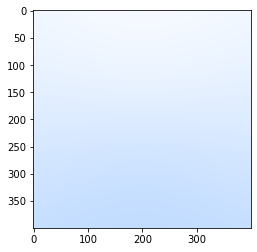

In [5]:
%matplotlib inline
imgplot = plt.imshow(image)
plt.show()